In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**BÁO CÁO BÀI TẬP LỚN HỌC MÁY CUỐI KỲ**

**Mã Lớp**: INT3405_1

**Họ và tên**: Nguyễn Diệp Yến

**MSSV**:18021455

-- **Topic: Classify toxic question** --

**1. VẤN ĐỀ BÀI TOÁN: Quora Insincere Classification**
>Quora là nền tảng nổi tiếng nơi mọi người đặt cho nhau những câu hỏi để học hỏi thêm nhiều thứ. Tuy nhiên có những câu hỏi được đặt ra mang tính nhạy cảm cho người đọc. Ta phải phân loại ra những câu hỏi mang tính tiêu cực, không đúng đắn.
* **Input** : Câu hỏi của Quora (dữ liệu text)
* **Output**: Label Sincere (0), Insincere (1)

In [ ]:
train_data = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_data = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")

**1.1. PHÂN TÍCH DỮ LIỆU**
* Dữ liệu có 3 thuộc tính: qid, question_text, target
* Khi phân loại, ta dùng thuộc tính question_text là đầu vào X, target là label y

In [ ]:
train_data

In [ ]:
train_data.info()

**Bỏ đi các dữ liệu NA, không tồn tại trong bảng.**

In [ ]:
train_data.dropna(inplace = True)
train_data

=> Từ dữ liệu được cho, ta thấy:
* 1306122 câu hỏi question_text chứa giá trị text data.
* 1306122 label target chứa giá trị 0, 1.
* Dữ liệu không chứa giá trị NA


**Giờ ta sẽ xem sự khác biệt giữa dữ liệu label 1, 0**

In [ ]:
toxic_data = train_data[train_data.target == 1]
non_toxic_data = train_data[train_data.target == 0]

**Những câu hỏi Sincere của Quora ( label target có giá trị 0 )**

In [ ]:
for d in non_toxic_data.question_text.sample(10):
  print(d)

**Những câu hỏi Insincere của Quora ( label target có giá trị 1 )**

In [ ]:
for d in toxic_data.question_text.sample(10):
  print(d)

**1.2. NHẬN XÉT VỀ DỮ LIỆU**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print(toxic_data.shape, non_toxic_data.shape)
print("--------------------------")

sns.countplot(x='target', data=train_data)

**Hình 1 - Bảng đếm số lượng dữ liệu label 0 và label 1**

In [ ]:
print( "Dữ liệu Insincere chiếm", toxic_data.shape[0] / train_data.shape[0])
print( "Dữ liệu Sincere chiếm", non_toxic_data.shape[0] / train_data.shape[0])

**Vấn đề**
>Trong dữ liệu train, có 80810 dữ liệu insincere (label 1) , 1225312 dữ liệu sincere (label 0).

  * Ở đây ta thấy dữ liệu insincere chỉ chiếm tỉ lệ 0.062
  * Còn so với dữ liệu sincere chiếm tỉ lệ 0.94 => Dữ liệu mất cân bằng
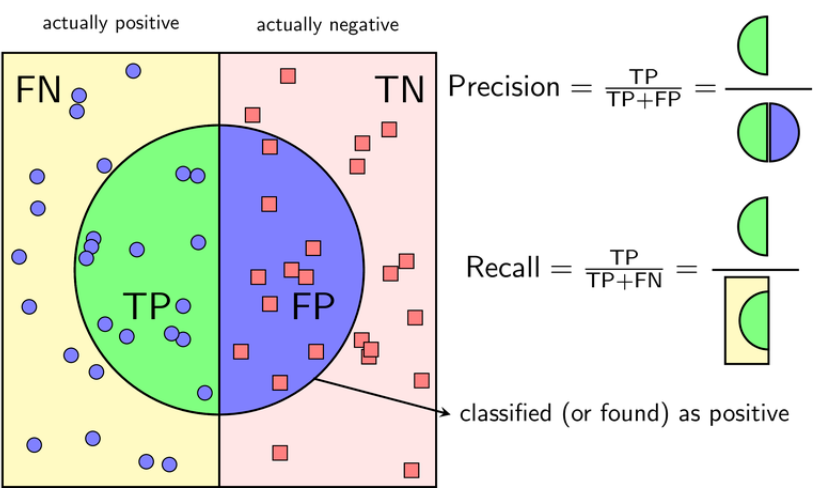

=> Độ đo sử dụng là F1-Score

**2. ĐỀ XUẤT HƯỚNG LÀM**

* **Tiền xử lý dữ liệu** (Bỏ dấu, chữ số, từ dừng, rút gọn, tách từ)
Unicode: Chuyển về dạng unicode
Lowercase : Chuyển về dạng in thường.
Punctuation, Remove Number: Bỏ dấu, chữ số.
Tokenize, Stopwords: Tách từ, Các từ dừng.
Lemmatizers: Rút gọn từ về dạng ngắn gọn.
=> Loại bỏ các từ không ý nghĩa, giúp ta xác định được các từ cần thiết để phân loại từ đó thuộc Label 1 hay 0.

* **Trích xuất dữ liệu**
Sử dụng CountVectorizer để trích xuất các từ, biến words thành dạng vectors ở dạng Bag-of-Words bằng cách đếm số lần xuất hiện của các từ trong bộ dữ liệu.

* **Huấn luyện mô hình**
Áp dụng mô hình học máy Logistic Regression, LinearSVC để huấn luyện, dự đoán. Sử dụng OverSampling thử xem kết quả như thế nào với mô hình trên.

**2.1. TIỀN XỬ LÝ**

(Code ở đây em tải về bộ từ điển định nghĩa sẵn trong NLTK)

In [ ]:
import re
import nltk
import string
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

contraction_dict = {"dont": "do not", "aint": "is not", "isnt": "is not", "doesnt": "does not"
, "cant": "cannot", "mustnt": "must not", "ll":"will" , "re": "are" ,"ll": "will", "wont": "will not" ,"hasnt": "has not"
, "havent": "have not", "arent": "are not", "ain't": "is not", "aren't": "are not"
,"can't": "cannot", "‘cause": "because", "could've": "could have"
, "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not"
, "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would"
,"he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you"
, "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have"
, "I'll": "I will", "I'll've": "I will have","I'm": "I am", "Iam": "I am", "I've": "I have"
, "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have"
,"i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have"
, "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us"
, "ma'am": "madam", "mayn't": "may not", "might've": "might have"
,"mightn't": "might not","mightn't've": "might not have", "must've": "must have"
, "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not"
, "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not"
, "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not"
, "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have"
, "she'll": "she will", "she'll've": "she will have", "she's": "she is"
, "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have"
, "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
"that'd've": "that would have", "that's": "that is", "there'd": "there would", 
"there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would"
, "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
"they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
"we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
"we'll've": "we will have", "we're": "we are", "we've": "we have", 
"weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
"what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
"who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
"why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
"y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", 
"you'll": "you will", "youll":"you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk_stopwords = stopwords.words('english')

nltk_stopwords.remove('not')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

(Định nghĩa hàm clean() để tiền xử lý các dữ liệu theo các bước đã nêu ở trên)

In [ ]:
def clean(text):        
    # chuyển từ về dạng unicode 
    text = unidecode(text).encode("ascii")
    text = str(text, "ascii")

    # chuyển về dạng chữ thường, bỏ các link, kí tự đặc biệt, chữ số.
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', ' ', text)  
    text = ''.join(i for i in text if not i.isdigit())

    # Chuyển các từ viết tắt trong từ điển về dạng thường
    tokens = word_tokenize(text)
    tokens = [contraction_dict.get(token) if (contraction_dict.get(token) != None) else token for token in tokens]
    text = " ".join(tokens)

    # Bỏ các từ chứa ở trong stop-words   
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in nltk_stopwords]

    # Chuyển từ về dạng số nhiều về dạng thường
    text = [lemmatizer.lemmatize(word) for word in tokens_without_sw ] 
    text = " ".join(text)

    return text

In [ ]:
word = clean("æœ‰æ¯’ they're you'll aren't mean in chinese takes taking taked")
print(word)

In [ ]:
train_data['clean_questions'] = train_data['question_text'].apply(clean)
train_data

In [ ]:
X = train_data['clean_questions']
y = train_data['target']

X.shape,y.shape

In [ ]:
train_data['target'].value_counts()

In [ ]:
non_toxic_data = X[y == 0]
toxic_data = X[y == 1]

print("Dữ liệu Label 0 (Tiền xử lý):\n ", non_toxic_data[:10])
print('\n---------------------------\n')
print("Dữ liệu Label 1 (Tiền xử lý):\n ",toxic_data[:10])

In [ ]:
from collections import Counter

# top 30 words in a non toxic data
p = Counter(" ".join(non_toxic_data).split()).most_common(30)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])

rslt.plot(x='Word',kind = "barh", figsize=(12,10), title="Top 30 từ sử dụng nhiều nhất của label 1")

In [ ]:
# top 30 words in a toxic data
p = Counter(" ".join(toxic_data).split()).most_common(30)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])

rslt.plot(x='Word',kind = "barh", figsize=(12,10), title="Top 30 từ sử dụng nhiều nhất của label 1")

Tách dữ liệu để huấn luyện mô hình, dự đoán kết quả

* Dữ liệu train = 80%
* Dữ liệu test = 20%

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

**2.2. VECTOR HÓA DỮ LIỆU**

* CountVectorizer N-gram = (1,3)
>=> Sử dụng CountVectorizer với n-gram trong khoảng [1,3] để trích xuất được trong khoảng 2 từ và 3 từ liên tiếp nhau.

* Trích xuất thêm dữ liệu để hiểu câu từ trong ngữ cảnh nào hơn.
>Giả sử như: ta có từ germany thì sẽ chưa hiểu nó là thuộc label nào.
Nhưng nếu mà ta trích được germany hitler => khả năng cao câu hỏi thuộc label 1.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))

In [ ]:
# Count Vectorizer
count_train = count_vectorizer.fit(X)

X_train_vec = count_train.transform(X_train)
X_test_vec = count_train.transform(X_test)

In [ ]:
X_test

In [ ]:
X_train

Thông thường CountVectorizer chỉ cần bigram là đủ.

**2.3. HUẤN LUYỆN MÔ HÌNH**

In [ ]:
# Thư viện
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
import numpy as np

from sklearn.metrics import accuracy_score, recall_score ,f1_score
from sklearn.metrics import classification_report

**Mô hình Logistic Regression**
>* Count Vectorizer với N-grams = [1,3]

In [ ]:
lr = LogisticRegression(class_weight = 'balanced', random_state=0, solver='liblinear')
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)

In [ ]:
def get_evaluation(predictions, test):
    print('Recall: ', recall_score(predictions, test))
    print('F1 score :', f1_score(predictions, test), '\n')
    print(classification_report(test, predictions))

In [ ]:
print("Logistic Regression with Count Vectorizer\n")
get_evaluation(y_pred, y_test)

**Mô hình SVC**
* Count Vectorizer với N-grams = [1,3]

In [ ]:
lsvc = LinearSVC(random_state=3, tol=0.01, loss='hinge', C=1, verbose=2, class_weight='balanced')

lsvc.fit(X_train_vec, y_train) 
y_pred2 = lsvc.predict(X_test_vec)

In [ ]:
print('-----------\n')
print("SVC with Count Vectorizer\n")
get_evaluation(y_pred2, y_test)

**Mô hình SVC + LR + Oversampling**
* Count Vectorizer với N-grams = [1,3]

In [ ]:
# define oversampling + undersampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5)

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_vec, y_train)

In [ ]:
from collections import Counter

print(Counter(y_over))
y_over.shape

In [ ]:
lr2 = LogisticRegression(class_weight='balanced', solver='liblinear')
lsvc2 = LinearSVC(class_weight='balanced')

lr2.fit(X_over, y_over)
y_pred3 = lr2.predict(X_test_vec)

In [ ]:
lsvc2.fit(X_over, y_over)
y_pred4 = lsvc2.predict(X_test_vec)

In [ ]:
print('Logistic Regression - Count Vectorizer - Oversampling')
get_evaluation(y_pred3, y_test)

In [ ]:
print('Linear SVC - Count Vectorizer - Oversampling')
get_evaluation(y_pred4, y_test)

**So sánh mô hình**
* Nhận xét: Kết quả mô hình không thay đổi sau lần OverSampling

In [ ]:
print("Logistic Regression with Count Vectorizer\n")
get_evaluation(y_pred, y_test)
print('-------------\n')
print("SVC with Count Vectorizer\n")
get_evaluation(y_pred2, y_test)
print('-------------\n')
print('Logistic Regression - Count Vectorizer - Oversampling')
get_evaluation(y_pred3, y_test)
print('-------------\n')
print('Linear SVC - Count Vectorizer - Oversampling')
get_evaluation(y_pred4, y_test)

Chọn mô hình Logistic Regression đầu tiên để kiểm tra.


**3. TẠO SUBMISSION**

In [ ]:
test_data['clean_questions'] = test_data['question_text'].apply(clean)
test_data

In [ ]:
X = test_data['clean_questions']

X.shape

In [ ]:
X_vec_test = count_vectorizer.transform(X)

In [ ]:
predictions = lr.predict(X_vec_test)

In [ ]:
predictions.shape

In [ ]:
test_data['prediction'] = predictions

results = test_data[['qid', 'prediction']]
results.to_csv('submission.csv', index=False)